In [1]:
#Loading and transforming images

!pip install Pillow==5.3.0

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms, datasets
from torch import nn
import torch.nn.functional as F

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

In [4]:
transform = transforms.Compose([transforms.Resize((28,28)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

training_dataset = datasets.MNIST(root ='./data',train = True, download= True, transform = transform )
validation_dataset = datasets.MNIST(root ='./data',train = False, download= True, transform = transform )

training_loader = torch.utils.data.DataLoader(dataset=training_dataset,batch_size=100,shuffle= True)
val_loader = torch.utils.data.DataLoader(dataset=validation_dataset,batch_size=100,shuffle= False)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
"""for inputs,labels in training_loader:
    print (inputs.shape)
    inputs = inputs.view(inputs.shape[0],-1)
    print (inputs)
    print (inputs.shape)
    break 
    """

'for inputs,labels in training_loader:\n    print (inputs.shape)\n    inputs = inputs.view(inputs.shape[0],-1)\n    print (inputs)\n    print (inputs.shape)\n    break \n    '

In [6]:
def image_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1,2,0)  # channels height width to height width channel 
  image = image*np.array((0.5,0.5,0.5,0.5))+np.array((0.5,0.5,0.5,0.5))
  image = image.clip(0,1)
  return image

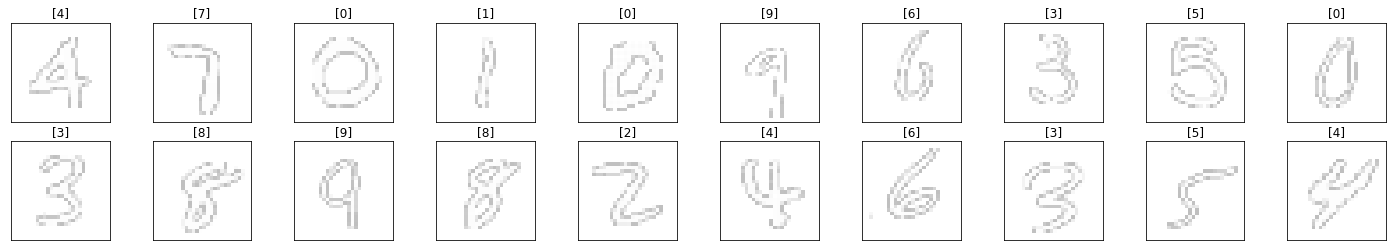

In [7]:
dataiter = iter(training_loader)
images,labels = dataiter.next()
fig = plt.figure(figsize =(25,4))

for index in np.arange(20):
  ax = fig.add_subplot(2,10,index+1,xticks=[],yticks=[])
  plt.imshow(image_convert(images[index]))
  ax.set_title ([labels[index].item()])



In [8]:
class LeNet(nn.Module):
  def __init__(self,):
    super().__init__()
    self.conv1=nn.Conv2d(1,20,5,1) 
    self.conv2=nn.Conv2d(20,50,5,1)  
    self.fc1= nn.Linear(4*4*50,500)
    self.dropout1 = nn.Dropout(0.5)
    self.fc2= nn.Linear(500,10)



  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x,2,2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x,2,2)
    x = x.view(-1,4*4*50)
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = self.fc2(x)
  
    return x



In [9]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)

In [11]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_his = []
val_running_correct_his = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss= 0.0
  val_correct = 0.0

  for inputs,labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)

    loss = criterion(outputs,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _,preds= torch.max(outputs,1)
    running_corrects+=torch.sum(preds == labels.data)


    running_loss+=loss.item()
  
  else:
    with torch.no_grad():
      for val_inputs,val_labels in val_loader:
        
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)

        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs,val_labels)

        _,val_preds= torch.max(val_outputs,1)
        val_correct+=torch.sum(val_preds == val_labels.data)
        val_running_loss+=val_loss.item()

    epoch_loss= running_loss/len(training_loader)
    epoch_accuracy= running_corrects.float()/len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_accuracy)

    val_epoch_loss= val_running_loss/len(val_loader)
    val_epoch_accuracy= val_correct.float()/len(val_loader) 
    val_running_loss_his.append(val_epoch_loss)
    val_running_correct_his.append(val_epoch_accuracy)

    print ('epoch:', (e+1))

    print ("Training loss: {:.4f}, acc {:.4f}".format(epoch_loss,epoch_accuracy.item()))
    print ("Validation loss: {:.4f}, acc {:.4f}".format(val_epoch_loss,val_epoch_accuracy.item()))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch: 1
Training loss: 0.5918, acc 84.2200
Validation loss: 0.1900, acc 94.7600
epoch: 2
Training loss: 0.1511, acc 95.6217
Validation loss: 0.1018, acc 97.0900
epoch: 3
Training loss: 0.0974, acc 97.0667
Validation loss: 0.0733, acc 97.9000
epoch: 4
Training loss: 0.0748, acc 97.7733
Validation loss: 0.0600, acc 98.1700
epoch: 5
Training loss: 0.0615, acc 98.1267
Validation loss: 0.0525, acc 98.3600
epoch: 6
Training loss: 0.0527, acc 98.4233
Validation loss: 0.0468, acc 98.5400
epoch: 7
Training loss: 0.0468, acc 98.5683
Validation loss: 0.0393, acc 98.7400
epoch: 8
Training loss: 0.0419, acc 98.7033
Validation loss: 0.0360, acc 98.8100
epoch: 9
Training loss: 0.0379, acc 98.8733
Validation loss: 0.0358, acc 98.7300
epoch: 10
Training loss: 0.0354, acc 98.8683
Validation loss: 0.0336, acc 98.9000
epoch: 11
Training loss: 0.0322, acc 99.0217
Validation loss: 0.0325, acc 98.9500
epoch: 12
Training loss: 0.0292, acc 99.0950
Validation loss: 0.0342, acc 98.8800
epoch: 13
Training loss: 

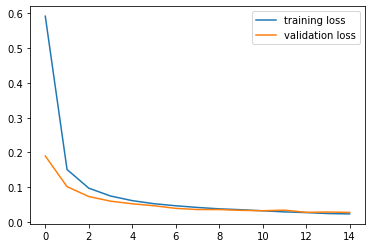

In [12]:
# labeprint (running_loss_history)
plt.plot(running_loss_history,label='training loss')
plt.plot(val_running_loss_his,label='validation loss')
plt.legend()

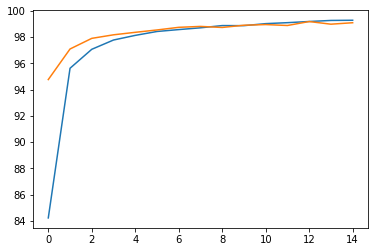

In [13]:
plt.plot(running_corrects_history,label='training_Accuracy')
plt.plot(val_running_correct_his,label ="Validation Accuracy")

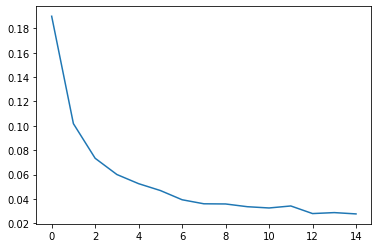

In [14]:
plt.plot(val_running_loss_his,label='training_Accuracy')

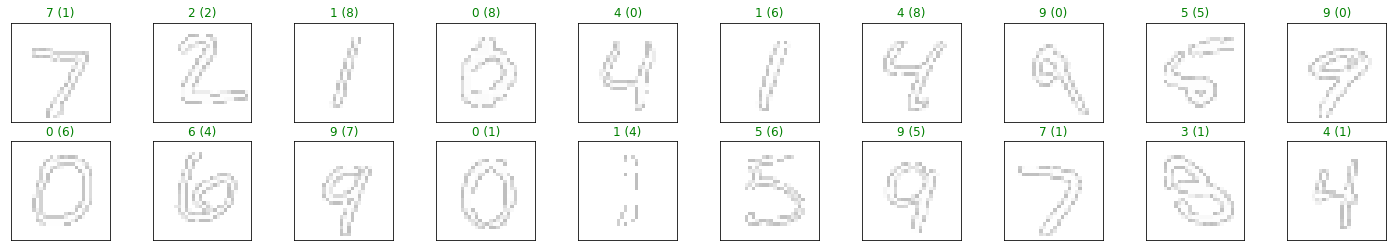

In [20]:
dataiter = iter(val_loader)
images, label = dataiter.next()
images = images.to(device)
label = label.to(device)
output = model(images)
_,preds= torch.max(output,1)

fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
  ax = fig.add_subplot(2,10,idx+1,xticks=[],yticks=[])
  plt.imshow(image_convert(images[idx]))
  ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),color=("green" if preds[idx]==label[idx] else "red"))